# Neural Parameter Estimation for SIR models

---------------------------------
Device:  cpu
Initial random value of beta: 0.124
---------------------------------
Data Settings
Data dimensions:  32
Physics dimensions:  80
Real beta of Numerical Solution: 0.61
---------------------------------
Starting training of neural networks...
Epoch: 120, Loss: 8.855e-01, Time: 22.4, gl: 72.24, pk: 731.43, ratio:0.10 || beta:0.158, gamma:0.10
Epoch: 180, Loss: 6.578e-01, Time: 37.0, gl: 27.95, pk: 283.50, ratio:0.10 || beta:0.180, gamma:0.10
Epoch: 240, Loss: 4.802e-01, Time: 51.5, gl: 0.00, pk: 10.45, ratio:0.00 || beta:0.203, gamma:0.10
Epoch: 300, Loss: 3.353e-01, Time: 66.8, gl: 0.00, pk: 14.29, ratio:0.00 || beta:0.231, gamma:0.10
Epoch: 360, Loss: 2.288e-01, Time: 81.5, gl: 0.00, pk: 14.68, ratio:0.00 || beta:0.259, gamma:0.10
Epoch: 420, Loss: 1.587e-01, Time: 96.9, gl: 0.00, pk: 16.16, ratio:0.00 || beta:0.285, gamma:0.10
Epoch: 480, Loss: 1.135e-01, Time: 111.9, gl: 0.00, pk: 17.17, ratio:0.00 || beta:0.306, gamma:0.10
Epoch: 540, Lo

C:\Users\user\AppData\Local\Temp\ipykernel_15736\1298683630.py:194: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(len(lf_list)),np.log(lf_list), c='orange')


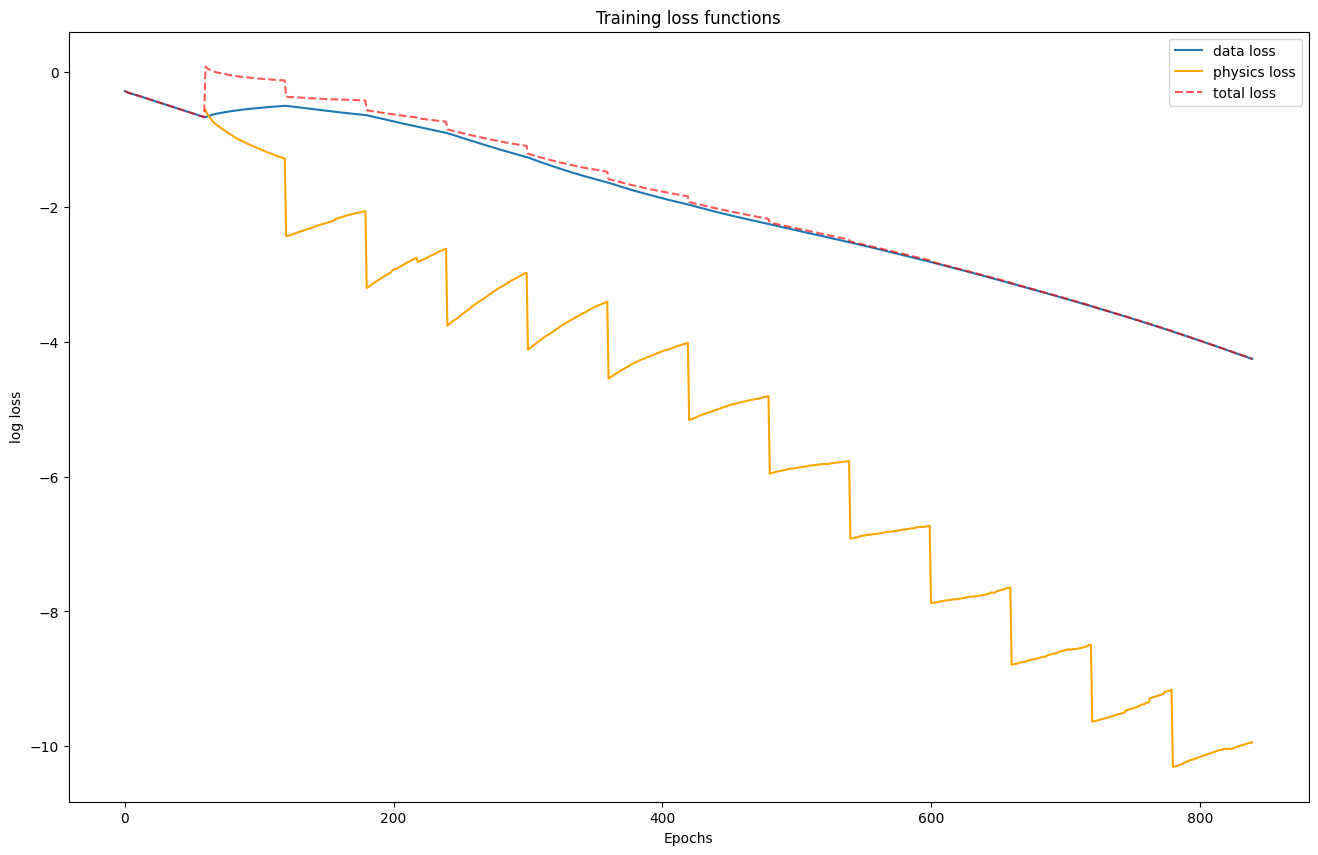

In [4]:
print('---------------------------------')
import timeit
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random as rd
import torch.nn.functional as F
from scipy.stats import bernoulli
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import copy


plt.rcParams['figure.figsize'] = [16, 10]


# Define the class for the neural network
class NN(nn.Module):
    def __init__(self,
                 num_inputs = 1,
                 num_outputs = 1,
                 num_hidden = 3,
                 hidden_neurons = 40,
                 activation = nn.Tanh):
        super().__init__()
        # self.num_inputs = num_inputs
        # self.num_outputs = num_outputs
        # self.num_hidden = num_hidden
        # self.activation = activation

        # Input layer
        self.fci = nn.Sequential(*[
                        nn.Linear(num_inputs, hidden_neurons),
                        activation()])

        # Hidden layers
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(hidden_neurons, hidden_neurons),
                            activation()]) for _ in range(num_hidden)])

        # Output layer
        self.fco = nn.Sequential(*[nn.Linear(hidden_neurons, num_outputs), activation()])
        # self.fco = nn.Linear(hidden_neurons, num_outputs)

    def forward(self,x):
        x = self.fci(x)
        x = self.fch(x)
        x = self.fco(x)
        return x

# Dynamics informed Neural Network
class DNet():
    def __init__(self, t_data, data_list, minlist, maxlist, t_physics, param, nndata):

        # Time for data points and residual of physics
        self.t_data = torch.tensor(t_data, requires_grad=True).view(-1,1).float().to(device=device)
        self.t_physics = torch.tensor(t_physics, requires_grad=True).view(-1,1).float().to(device=device)

        # Data points
        self.u_data = []
        for elem in data_list:
            self.u_data.append(torch.tensor(elem, requires_grad=True).view(-1,1).float().to(device=device))

        # minmax scaling settings
        self.minlist = minlist
        self.maxlist = maxlist

        self.beta = torch.tensor([param[0]], requires_grad=True).to(device=device)
        self.gamma = torch.tensor([param[1]], requires_grad=True).to(device=device)
        # self.gamma = torch.nn.Parameter(self.gamma)
        # Randomize beta
        # Initialize beta with a random value (you can also use custom initialization)
        self.beta = torch.tensor([rd.uniform(0.05,0.95)], requires_grad=True).to(device=device)
        print('Initial random value of beta: %.3f' %self.beta)
        # Load the neural network(s)
        self.models = []
        self.optimizers = []
        for dim in range(len(self.u_data)):
                network = NN(
                    num_inputs = nndata['num_inputs'],
                    num_outputs = nndata['num_outputs'],
                    num_hidden =  nndata['num_hidden'],
                    hidden_neurons = nndata['hidden_neurons'],
                    activation = nndata['activation'],
                ).to(device=device)
                self.models.append(network)


        # Register parameters for Neural network
        self.beta = torch.nn.Parameter(self.beta)
#         for network in self.models:
#             network.register_parameter('b', self.beta)

        # Define optimizer (ADAM)
        # self.optimizer = torch.optim.Adam([{'params': network.parameters()} for network in self.models], lr=1e-7)
        self.optimizers = []
        for network in self.models:
            self.optimizers.append(torch.optim.Adam([
                {'params': network.parameters()},  # For other parameters (e.g., weights and biases)
                {'params': self.beta, 'lr': 1e-5}  # For the "beta" parameter
            ], lr=1e-7))
            # self.optimizers.append(torch.optim.Adam(network.parameters(), lr=1e-5))

    #----------------------------------------------------------------------------
    # DYNAMICS
    #---------------------------------------------------------------------------
    def SIR_dynamics(self,t):
        # Apply model
        u_list = []
        for network in self.models:
            u_list.append(network(t))

        # Inverse Scalings (Inv. minmax-> Inv. Log -> Normal data)
        inv_results = inverse_minmax(u_list,self.minlist,self.maxlist)
        u = []
        for tensor in inv_results:
            u.append(torch.exp(tensor))

        # Compartments and derivatives
        du = []
        for tensor in u:
            du.append(torch.autograd.grad(tensor, t, torch.ones_like(tensor), create_graph=True)[0])

        # Parameters
        beta = self.beta
        gamma = self.gamma

        # SIR Residuals
        f0 = du[0] + beta*u[0]*u[1]
        f1 = du[1] - beta*u[0]*u[1] + gamma*u[1]
        return f0**2+f1**2
    #----------------------------------------------------------------------------

    #----------------------------------------------------------------------------
    # DATA LOSS
    #----------------------------------------------------------------------------
    def data_loss(self,t):
        # Apply model
        sc_u = []
        for network in self.models:
            sc_u.append(network(t))

        # Compartments
        f = []
        for i in range(len(sc_u)):
            f.append(sc_u[i]-self.u_data[i])
        # Data loss
        f = f[0]**2 + f[1]**2
        return f

    def batched_data_loss(self,t,u):
        sc_u = []
        for network in self.models:
            sc_u.append(network(t))

        # Dloss compartments
        f = []
        for i in range(len(sc_u)):
            f.append(sc_u[i]-u[i])

        # Data loss
        f = f[0]**2 + f[1]**2
        return f
    #----------------------------------------------------------------------------

    #----------------------------------------------------------------------------
    # PLOT TEST FUNCTION
    #----------------------------------------------------------------------------
    def plot_test(self):
        tarray = torch.linspace(0,t_final,600).view(-1,1)

        # Apply model
        u_list = []
        for network in self.models:
            u_list.append(network(tarray))

        # Inverse Scalings (Inv. minmax-> Inv. Log -> Normal data)
        inv_results = inverse_minmax(u_list,self.minlist,self.maxlist)
        u = []
        for tensor in inv_results:
            u.append(torch.exp(tensor))
        return

    #----------------------------------------------------------------------------
    # PLOT LOSS HISTORY
    #----------------------------------------------------------------------------
    def loss_history(self, lu_list, lf_list):
        plt.plot(range(len(lu_list)),np.log(lu_list))
        plt.plot(range(len(lf_list)),np.log(lf_list), c='orange')
        plt.plot(range(len(lu_list)), np.log(np.array(lu_list)+np.array(lf_list)), c='red', ls='dashed', alpha=0.66)
        plt.title('Training loss functions')
        plt.xlabel('Epochs')
        plt.ylabel('log loss')
        plt.legend(['data loss', 'physics loss', 'total loss'])
        plt.show()
        return
    #----------------------------------------------------------------------------
    # TRAINING
    #----------------------------------------------------------------------------
    def only_data_training(self,nIter,dataloader,total_loss):
        lu_list = []
        lf_list = []
        for epoch in range(nIter):
            loss1 = 0
            for inputs, targets1, targets2 in dataloader:

                for optimizer in self.optimizers:
                    optimizer.zero_grad()

                # Data
                inputs = torch.stack(inputs).to(device)
                targets1 = torch.stack(targets1).to(device)
                targets2 = torch.stack(targets2).to(device)

                # Data Loss
                loss_u = torch.mean(self.batched_data_loss(inputs, [targets1,targets2]))
                loss1 = loss1 + loss_u.item()

                # Total Loss
                loss = loss_u
                loss.backward()

                for optimizer in self.optimizers:
                    optimizer.step()

            lu_list.append(loss1/len(dataloader))
            lf_list.append(0)
            total_loss.append(lu_list[-1])
        return lu_list, lf_list, total_loss


    def train(self, nIter):
        # self.model.train()
        start_time = timeit.default_timer()

        # Create a combined training dataset
        dataset = TensorDataset(self.t_data, self.u_data[0], self.u_data[1])

        # Loss History
        lu_list = []
        lf_list = []
        total_loss = []

        # Stoping conditions parameters
        kslice = 10
        t = nIter

        # Prepare alphalist
        alist = []
        for i in range(13):
            alist.append(10**(-i/2))
        # for i in range(4,8):
        #     alist.append(10**(-i/2))
        #     alist.append(10**(-i/2))

        # Create a DataLoader with the custom collate function
        batch_size = 1
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

        # Only data Training
        lu_list, lf_list, total_loss = self.only_data_training(nIter,dataloader,total_loss)

        # Loss Balancing Initialization
        loss_u = torch.mean(self.data_loss(self.t_data))
        loss_f = torch.mean(self.SIR_dynamics(self.t_physics))
        w = loss_u.item()/loss_f.item()

        # Begin Training
        for alpha in alist:
            for epoch in range(nIter):
                t = t + 1
                loss1 = 0
                loss2 = 0
                for inputs, targets1, targets2 in dataloader:

                    for optimizer in self.optimizers:
                        optimizer.zero_grad()

                    # Data
                    inputs = torch.stack(inputs).to(device)
                    targets1 = torch.stack(targets1).to(device)
                    targets2 = torch.stack(targets2).to(device)

                    # Data Loss
                    loss_u = torch.mean(self.batched_data_loss(inputs, [targets1,targets2]))
                    loss1 = loss1 + loss_u.item()

                    # Physics Loss
                    loss_f = w*alpha*torch.mean(self.SIR_dynamics(inputs))
                    loss2 = loss2 + loss_f.item()

                    # Total Loss
                    loss = loss_u + loss_f
                    loss.backward()

                    for optimizer in self.optimizers:
                        optimizer.step()

                # Losses
                lu_list.append(loss1/len(dataloader))
                lf_list.append(loss2/len(dataloader))
                total_loss.append(loss1/len(dataloader)+loss2/len(dataloader))

                # Stopping Condition: PK - https://link.springer.com/content/pdf/10.1007/3-540-49430-8_3.pdf
                if (t) % kslice == 0:
                    gl = 100*(total_loss[-1]/min(total_loss) - 1)
                    pk = 1000*(sum(total_loss[-kslice:])/(kslice*min(total_loss)) - 1)
                    # print('GL: %2.f, PK: %2.f' %
                    #       (gl, pk))
                    if gl/pk>0.8:
                        print('-------Stopping condition for alpha section-------')
                        print('Last epoch: %d, Loss: %.3e, Time: %.1f, Stopping Ratio: %2.f' %
                          (t, loss.item(), elapsed, gl/pk))
                        print('---------------------RESUMING---------------------')
                        break
                if (t) % nIter == 0:
                    elapsed = timeit.default_timer() - start_time
                    print('\rEpoch: %d, Loss: %.3e, Time: %.1f, gl: %.2f, pk: %.2f, ratio:%.2f || beta:%.3f, gamma:%.2f' %
                          (t, total_loss[-1], elapsed, gl, pk, gl/pk, self.beta, self.gamma))

        print('Total Number of Epochs: %d, Final Value of beta: %.3f' %(t, self.beta) )
        self.loss_history(lu_list, lf_list)
        # self.plot_test()
    #----------------------------------------------------------------------------

    #----------------------------------------------------------------------------
    # PREDICTION
    #----------------------------------------------------------------------------
    def predict(self, t):
        with torch.no_grad():
            # Apply model
            out_data = []
            for network in self.models:
                network.eval()
                out_data.append(network(t))
        return out_data

#--------------------------------------------------------
# Additional Activation functions
#--------------------------------------------------------
class ReLU1(nn.Module):
    def __init__(self, inplace=False):
        super(ReLU1, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        f = torch.max(x, torch.zeros_like(x), out=x if self.inplace else None)
        f = torch.clamp(f, max=1.0)
        return f

class ClampTanh(nn.Module):
    def __init__(self, inplace=False):
        super(ClampTanh, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        f = nn.Tanh(x)
        f = torch.clamp(f, min=0.0, max=1.0)
        return f
#--------------------------------------------------------
# Define a custom collate function to split the targets
#--------------------------------------------------------
def custom_collate(batch):
    inputs = [item[0] for item in batch]
    targets1 = [item[1] for item in batch]
    targets2 = [item[2] for item in batch]
    return inputs, targets1, targets2
#--------------------------------------------------------

#--------------------------------------------------------
# Define the SIR differential equations
#--------------------------------------------------------
def SIR_eqs(z,t,beta,k,n):
    dsdt = -beta*z[0]*z[1]/n
    didt = beta*z[0]*z[1]/n - k*z[1]
    drdt = k*z[1]
    dzdt = [dsdt,didt,drdt]
    return dzdt
#--------------------------------------------------------

#--------------------------------------------------------
# Min Max Scaling and inverse Scaling
#--------------------------------------------------------
def minmax_scaling(data):
    # Takes a numpy array with several columns and performs minmax for each column separately
    # The min and max listes are here to do the inverse min max afterwards
    minlist = []
    maxlist = []
    scaled_data = []
    for column in data.T:
        minvar = (min(column))
        maxvar = (max(column))
        sc_var = (column - minvar)/(maxvar-minvar)
        minlist.append(minvar)
        maxlist.append(maxvar)
        scaled_data.append(sc_var)
    return scaled_data, minlist, maxlist

def inverse_minmax(sc_data, minlist, maxlist):
    # Performs the inverse min max scaling to return to normal data
    data = []
    for i in range(len(sc_data)):
        var = sc_data[i]*(maxlist[i]-minlist[i])+minlist[i]
        data.append(var)
    return data
#--------------------------------------------------------

# Initialization
torch.manual_seed(42)
gamma = 1/10
n_pop = 10
beta = round(rd.uniform(0.2, 0.95),2)
params = [beta, gamma, n_pop]
i0 = 1

# System Solver
t_final = 40
Nt = t_final
t_data = np.linspace(0, t_final, Nt+1)
Z0 = [n_pop-i0,i0,0] # Initial condition
sol = odeint(SIR_eqs,Z0,t_data, tuple(params))/n_pop

# Physics Settings
noise = 0.0
t_physics = np.linspace(0,t_final,Nt*2)

# Numerical solution with scalings
u_log = np.log(sol[:,:2])
u_scaled, minlist, maxlist = minmax_scaling(u_log)

# Collocation points
u_train = []
for elem in u_scaled:
    u_train.append(elem[0:32:1])
t_train = t_data[0:32:1]

# Dictionary with architecture
nndict = {}
nndict['num_inputs'] = 1
nndict['num_outputs'] = 1
nndict['num_hidden'] = 10
nndict['hidden_neurons'] = 128
nndict['activation'] = nn.SELU

# randbeta = round(rd.uniform(0.10, 0.99),2)
# params = [randbeta, gamma, n_pop]
# Model initialization
model = DNet(t_train, u_train, minlist, maxlist, t_physics, params, nndict)
print('---------------------------------')
print('Data Settings')
print('Data dimensions: ', len(t_train))
print('Physics dimensions: ', len(t_physics))
print('Real beta of Numerical Solution: %.2f' %beta)
print('---------------------------------')
print('Starting training of neural networks...')
model.train(60)